In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle

In [87]:
df = pd.read_csv('DNN-EdgeIIoT-dataset.csv')

/var/folders/5n/5nt9ztr10sx56m052vljdpfw0000gn/T/ipykernel_73988/2769549640.py:1: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('DNN-EdgeIIoT-dataset.csv')


In [88]:
drop_columns = ['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.src.proto_ipv4','arp.dst.proto_ipv4', 'http.file_data','http.request.full_uri','icmp.transmit_timestamp','http.request.uri.query', 'tcp.options','tcp.payload','tcp.srcport','tcp.dstport', 'udp.port', 'mqtt.msg', 'Attack_label']
df = df.drop(drop_columns, axis=1)
df = df.dropna(axis=0)
df = df.drop_duplicates()

In [89]:
df['Attack_type'].value_counts()

Attack_type
Normal                   1380858
DDoS_UDP                  121567
DDoS_ICMP                  67939
SQL_injection              50826
DDoS_TCP                   50062
Vulnerability_scanner      50026
Password                   49933
DDoS_HTTP                  49203
Uploading                  36915
Backdoor                   24026
Port_Scanning              19983
XSS                        15066
Ransomware                  9689
Fingerprinting               853
MITM                         358
Name: count, dtype: int64

In [90]:
df.columns

Index(['arp.opcode', 'arp.hw.size', 'icmp.checksum', 'icmp.seq_le',
       'icmp.unused', 'http.content_length', 'http.request.method',
       'http.referer', 'http.request.version', 'http.response',
       'http.tls_port', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum',
       'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn',
       'tcp.connection.synack', 'tcp.flags', 'tcp.flags.ack', 'tcp.len',
       'tcp.seq', 'udp.stream', 'udp.time_delta', 'dns.qry.name',
       'dns.qry.name.len', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission',
       'dns.retransmit_request', 'dns.retransmit_request_in',
       'mqtt.conack.flags', 'mqtt.conflag.cleansess', 'mqtt.conflags',
       'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mqtt.msgtype',
       'mqtt.proto_len', 'mqtt.protoname', 'mqtt.topic', 'mqtt.topic_len',
       'mqtt.ver', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id',
       'Attack_type'],
      dtype='object')

In [91]:
categorical_columns = ['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags', 'mqtt.protoname', 'mqtt.topic']
for column in categorical_columns:
    dummies = pd.get_dummies(df[column])
    for d_col in dummies.columns:
        dummy_name = f'{column}_{d_col}'
        df[dummy_name] = dummies[d_col].astype(int)
    df = df.drop(column, axis=1)

In [92]:
df.dtypes

arp.opcode                             float64
arp.hw.size                            float64
icmp.checksum                          float64
icmp.seq_le                            float64
icmp.unused                            float64
                                        ...   
mqtt.protoname_0                         int64
mqtt.protoname_MQTT                      int64
mqtt.topic_0.0                           int64
mqtt.topic_0                             int64
mqtt.topic_Temperature_and_Humidity      int64
Length: 96, dtype: object

In [93]:
labels = df['Attack_type']
df = df.drop(columns=['Attack_type'])

In [94]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels.values.ravel())

In [95]:
labels

array([7, 7, 7, ..., 2, 2, 2])

In [96]:
numeric_columns = ['arp.opcode', 'arp.hw.size', 'icmp.checksum', 'icmp.seq_le','icmp.unused', 'http.content_length', 'http.response','http.tls_port', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum','tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn','tcp.connection.synack', 'tcp.flags', 'tcp.flags.ack', 'tcp.len','tcp.seq', 'udp.stream', 'udp.time_delta', 'dns.qry.name','dns.qry.qu', 'dns.qry.type', 'dns.retransmission','dns.retransmit_request', 'dns.retransmit_request_in','mqtt.conflag.cleansess', 'mqtt.conflags','mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mqtt.msgtype','mqtt.proto_len', 'mqtt.topic_len','mqtt.ver', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id']
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [97]:
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=69)

In [98]:
len(x_train.columns)

95

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [100]:
class DNNMulticlass(nn.Module):

    def __init__(self):
        super().__init__()
        self.ll1 = nn.Linear(95, 128) # 36 features => X_train.shape[1]
        self.ll2 = nn.Linear(128, 256)
        self.ll3 = nn.Linear(256, 256)
        self.last = nn.Linear(256, 15) # 15 classifications =>  y_train.value_counts()

    def forward(self, x):
        x = F.relu(self.ll1(x))
        x = F.relu(self.ll2(x))
        x = F.relu(self.ll3(x))  
        x = self.last(x) 
        return x

In [101]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [103]:
X_train_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(x_test.to_numpy(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [104]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=250)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=250)

In [105]:
model_dnn = DNNMulticlass()
early_stopping = EarlyStopping(patience=5, delta=0.001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_dnn.parameters(), lr=0.001)

training_losses = []
validation_losses = []

epochs = 50 # Training rounds
for epoch in range(epochs): 
    model_dnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()

        # Feed forward + backpropogate
        outputs = model_dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_dnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model_dnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Finished Training')

Epoch [1/50], Training Loss: 0.1204, Validation Loss: 0.1121
Epoch [2/50], Training Loss: 0.1089, Validation Loss: 0.0984
Epoch [3/50], Training Loss: 0.1006, Validation Loss: 0.0965
Epoch [4/50], Training Loss: 0.0978, Validation Loss: 0.0952
Epoch [5/50], Training Loss: 0.0964, Validation Loss: 0.0943
Epoch [6/50], Training Loss: 0.0956, Validation Loss: 0.0964
Epoch [7/50], Training Loss: 0.0954, Validation Loss: 0.0938
Epoch [8/50], Training Loss: 0.0949, Validation Loss: 0.0956
Epoch [9/50], Training Loss: 0.0952, Validation Loss: 0.0940
Epoch [10/50], Training Loss: 0.0947, Validation Loss: 0.0991
Epoch [11/50], Training Loss: 0.0948, Validation Loss: 0.0933
Epoch [12/50], Training Loss: 0.0947, Validation Loss: 0.0936
Early stopping triggered
Finished Training


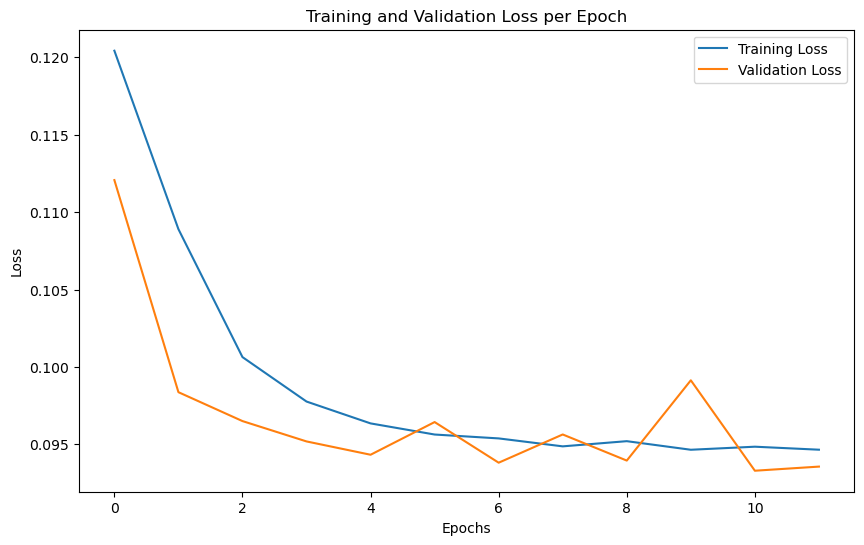

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()